# <center> Feature engineering: TSFresh performance

In [26]:
%store -r __ipy
%store -r __da

In [27]:
__ipy

Helper ipython script loaded


In [28]:
__da

Basic Data Analysis tools was loaded


In [16]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters ,ComprehensiveFCParameters
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

In [17]:
train_df = pd.read_pickle(root + 'train_df.pkl')

In [18]:
n_samples = 100000
segments = train_df.shape[0] / n_samples

In [19]:
train_df = pd.read_pickle(root + "train_features.pkl")
train_t = train_df[:n_samples]

def tsfresh_time(sett, column_sort, column_value, res):
    for f, param in tqdm(sett.items()):
        res.loc[f, "feature"] = f
        fc_dict = {f:param}
        t = timeit.timeit(lambda : extract_features(train_t, 
                         column_id=KEY_NAME,
                         column_sort=column_sort,
                         column_value=column_value,
                         n_jobs=12, 
                         default_fc_parameters=fc_dict, 
                         disable_progressbar=True), 
                         number=3)
        
        res.loc[f, "t_abs"] = t
    return res

def show_ts_performance(settings):
    res=pd.DataFrame()
    res=tsfresh_time(settings, 'timestamp', 'meter_reading_log1p', res)
    res["feature"] = res.feature.astype(str)
    res = res.sort_values(by="feature")

    plt.figure(figsize=(6, 10))
    sns.barplot(y="feature", x="t_abs", data=res)
    plt.title("Runtime of 1 apply features for 1 time series of length %d"  % n_samples)
    
    seconds = np.sum(res["t_abs"]) * segments
    print("Estimated running time: ", seconds)
    print("Estimated running time: ", seconds / 60)
    print("Estimated running time: ", seconds / 60 / 60)
    plt.show()

In [20]:
settings = {
'standard_deviation': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,

'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
'first_location_of_minimum': None,
'count_above_mean': None,
 'count_below_mean': None,
 'maximum': None,
 'minimum': None,

 'number_peaks': [{'n': 1}, {'n': 5}],
 'ar_coefficient': [{'coeff': 0, 'k': 10}]
}

{'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}


Estimated running time:  9640.023531082503


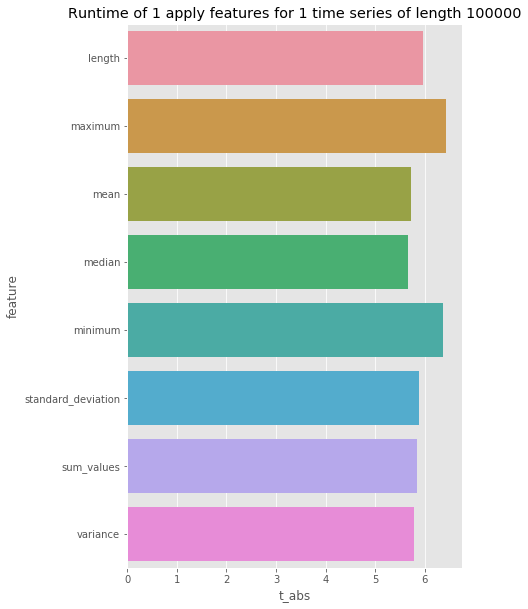

In [21]:
show_ts_performance(MinimalFCParameters())


Estimated running time:  98631.36630548758


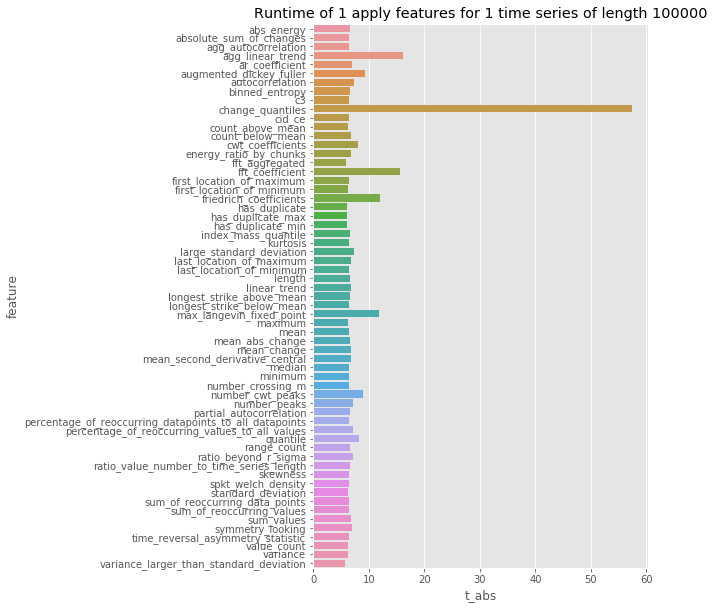

In [22]:
show_ts_performance(EfficientFCParameters())


Estimated running time:  103032.4573277634


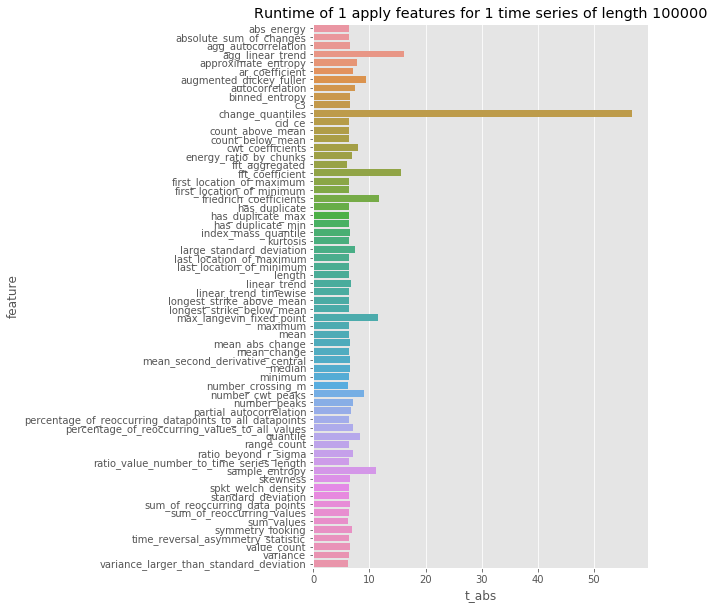

In [23]:
show_ts_performance(ComprehensiveFCParameters())

In [25]:
time_cols = ['month_datetime', 'weekofyear_datetime',
             'dayofyear_datetime', 'hour_datetime', 
             'day_week', 'day_month_datetime',
             'week_month_datetime']

In [ ]:
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit
tscv = KFold(n_splits=5)

start = time.time()

X = train_df[:n_samples]

def ts_features(train1, column_sort, column_value, settings):
    X=extract_features(train1, 
                     column_id=KEY_NAME,
                     column_sort=column_sort,
                     column_value=column_value,
                     default_fc_parameters=settings,
                     #impute_function= impute,
                     disable_progressbar=True,
                     show_warnings=True)
    return X


X_filtered = pd.DataFrame()

for i, (train_index, test_index) in tqdm(enumerate(tscv.split(X))):
    X_train = X.loc[test_index] 
    features = ts_features(X_train, 'hour_datetime', 'meter_reading',  MinimalFCParameters())
    X_filtered = pd.concat((X_filtered, features.add_suffix(f'_{i}')), axis=1)
    
#X_filtered=X_filtered.reset_index().drop(['id'], axis=1)

print(X_filtered.shape)

end = time.time()
print("Time",end - start)

In [ ]:
def ts_features(train1, column_sort, column_value, settings):
    X=extract_features(train1, 
                     column_id=KEY_NAME,
                     column_sort=column_sort,
                     column_value=column_value,
                     default_fc_parameters=settings,
                     impute_function= impute,
                     disable_progressbar=True,
                     show_warnings=True)
    return X

def generate_ts_features(X_train, y_col_name, time_cols, k_folds=5):
    tscv = KFold(n_splits=k_folds)
    
    start = time.time()

    X_filtered = pd.DataFrame()

    for time_col in time_cols:
        print(X_train.head())
        features = ts_features(X_train, time_col, y_col_name,  settings)

        for col in features.columns:
            features[col] = features[col].astype(np.float16)

        X_filtered = pd.concat((X_filtered, features.add_suffix(f'_{i}')), axis=1)
    
    X_filtered = X_filtered.replace([np.inf, -np.inf, np.nan], 0)
    impute(X_filtered)
    
    end = time.time()
    print("Time",end - start)
    
    return X_filtered


def generate_and_merge(X_train, X_test=None):
    features = generate_ts_features(X_train, 'meter_reading', ['hour_datetime'], k_folds=6)
    
    X_train = X_train.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    if X_test != None:
        X_test = X_test.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    return X_train, X_test


In [ ]:
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit

start = time.time()

X = train_df[:n_samples]
features = generate_ts_features(X, 'meter_reading_log1p', ['hour_datetime'], k_folds=6)

end = time.time()
print("Time",end - start)

In [34]:
settings = {
 'variance_larger_than_standard_deviation': None,
 'mean_abs_change': None,
 'mean_change': None,
 'median': None,
 'mean': None,
 'standard_deviation': None,
 'variance': None,
 'absolute_sum_of_changes': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'maximum': None,
 'minimum': None,
 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'autocorrelation': [
  {'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 6},
  {'lag': 12}],
 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40},
  {'f_agg': 'median', 'maxlag': 40},
  {'f_agg': 'var', 'maxlag': 40}],
 'partial_autocorrelation': 
  [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 6},
  {'lag': 12}],
 'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}, {'n': 10}, {'n': 50}],
 'linear_trend': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}],

 'augmented_dickey_fuller': [{'attr': 'teststat'},
  {'attr': 'pvalue'},
  {'attr': 'usedlag'}]}


Estimated running time:  28158.71494204907


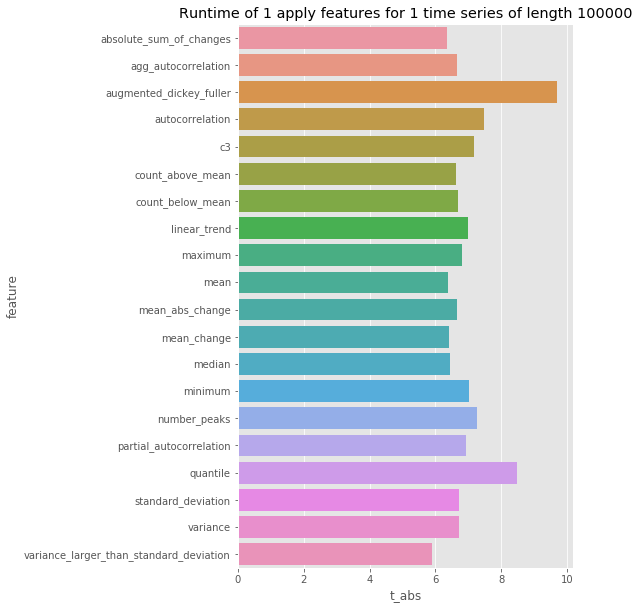

In [35]:
show_ts_performance(settings)